1. Extract Data from Kafka
First, extract the data from Kafka using a consumer. Libraries like kafka-python, confluent-kafka, or frameworks like Spark Streaming (with PySpark) can help you achieve this.

For example, using kafka-python:

In [1]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost confluent-kafka orjson



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\dayzd\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from confluent_kafka import Consumer, KafkaError
import json
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import csr_matrix
import numpy as np

# Kafka Consumer setup
consumer = Consumer({
    'bootstrap.servers': 'localhost:9095',
    'group.id': 'my-group',
    'auto.offset.reset': 'earliest'
})

consumer.subscribe(['elastiflow-flow-codex-2-1.0'])

data = []
message_count = 0  # Initialize the message counter

# Define a function to process each message
def process_message(msg):
    netflow_data = json.loads(msg.value().decode('utf-8'))  

    # Return the processed data
    return {
        "src_mac": netflow_data.get("flow.in.src.mac.addr"),
        "dst_mac": netflow_data.get("flow.in.dst.mac.addr"),
        "bytes": netflow_data.get("flow.bytes"),
        "packets": netflow_data.get("flow.packets"),
        "direction": netflow_data.get("flow.direction.name"),
        "protocol": netflow_data.get("l4.proto.name"),
        "client_as_label": netflow_data.get("flow.client.as.label"),
        "server_as_label": netflow_data.get("flow.server.as.label"),
        "client_as_org": netflow_data.get("flow.client.as.org"),
        "server_as_org": netflow_data.get("flow.server.as.org"),
        "start_offset": netflow_data.get("flow.start.time_offset"),
        "end_offset": netflow_data.get("flow.end.time_offset"),
        # New fields being added based on your suggestion and recommendations:
        "in_bytes": netflow_data.get("flow.in.bytes"),
        "in_bytes_sumsqrs": netflow_data.get("flow.in.bytes_sumsqrs"),
        "in_bytes_total": netflow_data.get("flow.in.bytes_total"),
        "in_bytes_total_sumsqrs": netflow_data.get("flow.in.bytes_total_sumsqrs"),
        "packets_bcast_in": netflow_data.get("flow.meter.observ.packets_bcast.in"),
        "packets_bcast_out": netflow_data.get("flow.meter.observ.packets_bcast.out"),
        "packets_mcast_in": netflow_data.get("flow.meter.observ.packets_mcast.in"),
        "packets_ucast_in": netflow_data.get("flow.meter.observ.packets_ucast.in"),
        "packets_ucast_out": netflow_data.get("flow.meter.observ.packets_ucast.out"),
        # Additional recommended fields
        "in_packets_total": netflow_data.get("flow.in.packets_total"),
        "bytes_drop": netflow_data.get("flow.treatment.bytes_drop"),
        "packets_drop": netflow_data.get("flow.treatment.packets_drop"),
        "out_packets_mcast_total": netflow_data.get("flow.out.packets_mcast_total"),
        "out_bytes_mcast_total": netflow_data.get("flow.out.bytes_mcast_total"),
        "ttl": netflow_data.get("ip.ttl"),
        "proto_name": netflow_data.get("l4.proto.name")
    }

with ThreadPoolExecutor(max_workers=10) as executor:
    while True:
        msgs = consumer.consume(num_messages=500, timeout=0.1)  # Fetch up to 500000 messages at once
        futures = [executor.submit(process_message, msg) for msg in msgs if msg is not None and not msg.error()]

        # Gather results as they complete
        for future in futures:
            result = future.result()
            if result:
                data.append(result)
                message_count += 1
                print(f"Message count: {message_count}")  # Print the current message count

        if len(data) >= 100000:  # Limit to 10000 records for testing
            break

consumer.close()


Message count: 1
Message count: 2
Message count: 3
Message count: 4
Message count: 5
Message count: 6
Message count: 7
Message count: 8
Message count: 9
Message count: 10
Message count: 11
Message count: 12
Message count: 13
Message count: 14
Message count: 15
Message count: 16
Message count: 17
Message count: 18
Message count: 19
Message count: 20
Message count: 21
Message count: 22
Message count: 23
Message count: 24
Message count: 25
Message count: 26
Message count: 27
Message count: 28
Message count: 29
Message count: 30
Message count: 31
Message count: 32
Message count: 33
Message count: 34
Message count: 35
Message count: 36
Message count: 37
Message count: 38
Message count: 39
Message count: 40
Message count: 41
Message count: 42
Message count: 43
Message count: 44
Message count: 45
Message count: 46
Message count: 47
Message count: 48
Message count: 49
Message count: 50
Message count: 51
Message count: 52
Message count: 53
Message count: 54
Message count: 55
Message count: 56
M

# Convert to DataFrame # 

In [2]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Handle missing values for fields that are already in the data
df.fillna(0, inplace=True)

# Ensure categorical columns are uniformly strings
for col in ['direction', 'protocol', 'client_as_label', 'server_as_label', 'client_as_org', 'server_as_org', 'proto_name']:
    df[col] = df[col].astype(str)

# Feature Engineering: Calculate ratios
df['byte_packet_ratio'] = df['bytes'] / df['packets'].replace(0, 1)  # Avoid division by zero
df['offset_ratio'] = df['start_offset'] / df['end_offset'].replace(0, 1)

# Define the list of features after they have been created
numerical_features = [
    'bytes', 'packets', 'byte_packet_ratio', 'start_offset', 'end_offset', 'offset_ratio',
    # New features added:
    'in_bytes', 'in_bytes_sumsqrs', 'in_bytes_total', 'in_bytes_total_sumsqrs',
    'packets_bcast_in', 'packets_bcast_out', 'packets_mcast_in', 'packets_ucast_in', 'packets_ucast_out',
    'in_packets_total', 'bytes_drop', 'packets_drop', 'out_packets_mcast_total', 'out_bytes_mcast_total', 'ttl'
]
categorical_features = ['direction', 'protocol', 'client_as_label', 'server_as_label', 'client_as_org', 'server_as_org', 'proto_name']

# Preprocessing: Scaling and Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply transformations
df_preprocessed = preprocessor.fit_transform(df)

# Convert the preprocessed data to dense format if it's a sparse matrix
if isinstance(df_preprocessed, csr_matrix):
    df_preprocessed = df_preprocessed.toarray()  # Convert to dense array

# Convert to a DataFrame for easier manipulation and feature naming
df_preprocessed = pd.DataFrame(df_preprocessed)

In [3]:
# Display basic statistics
df_preprocessed.describe()

# Check for any missing or infinite values after preprocessing
print("Missing values:\n", df_preprocessed.isnull().sum())
print("Infinite values:\n", df_preprocessed.isin([float('inf'), float('-inf')]).sum())


Missing values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
dtype: int64
Infinite values:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
dtype: int64


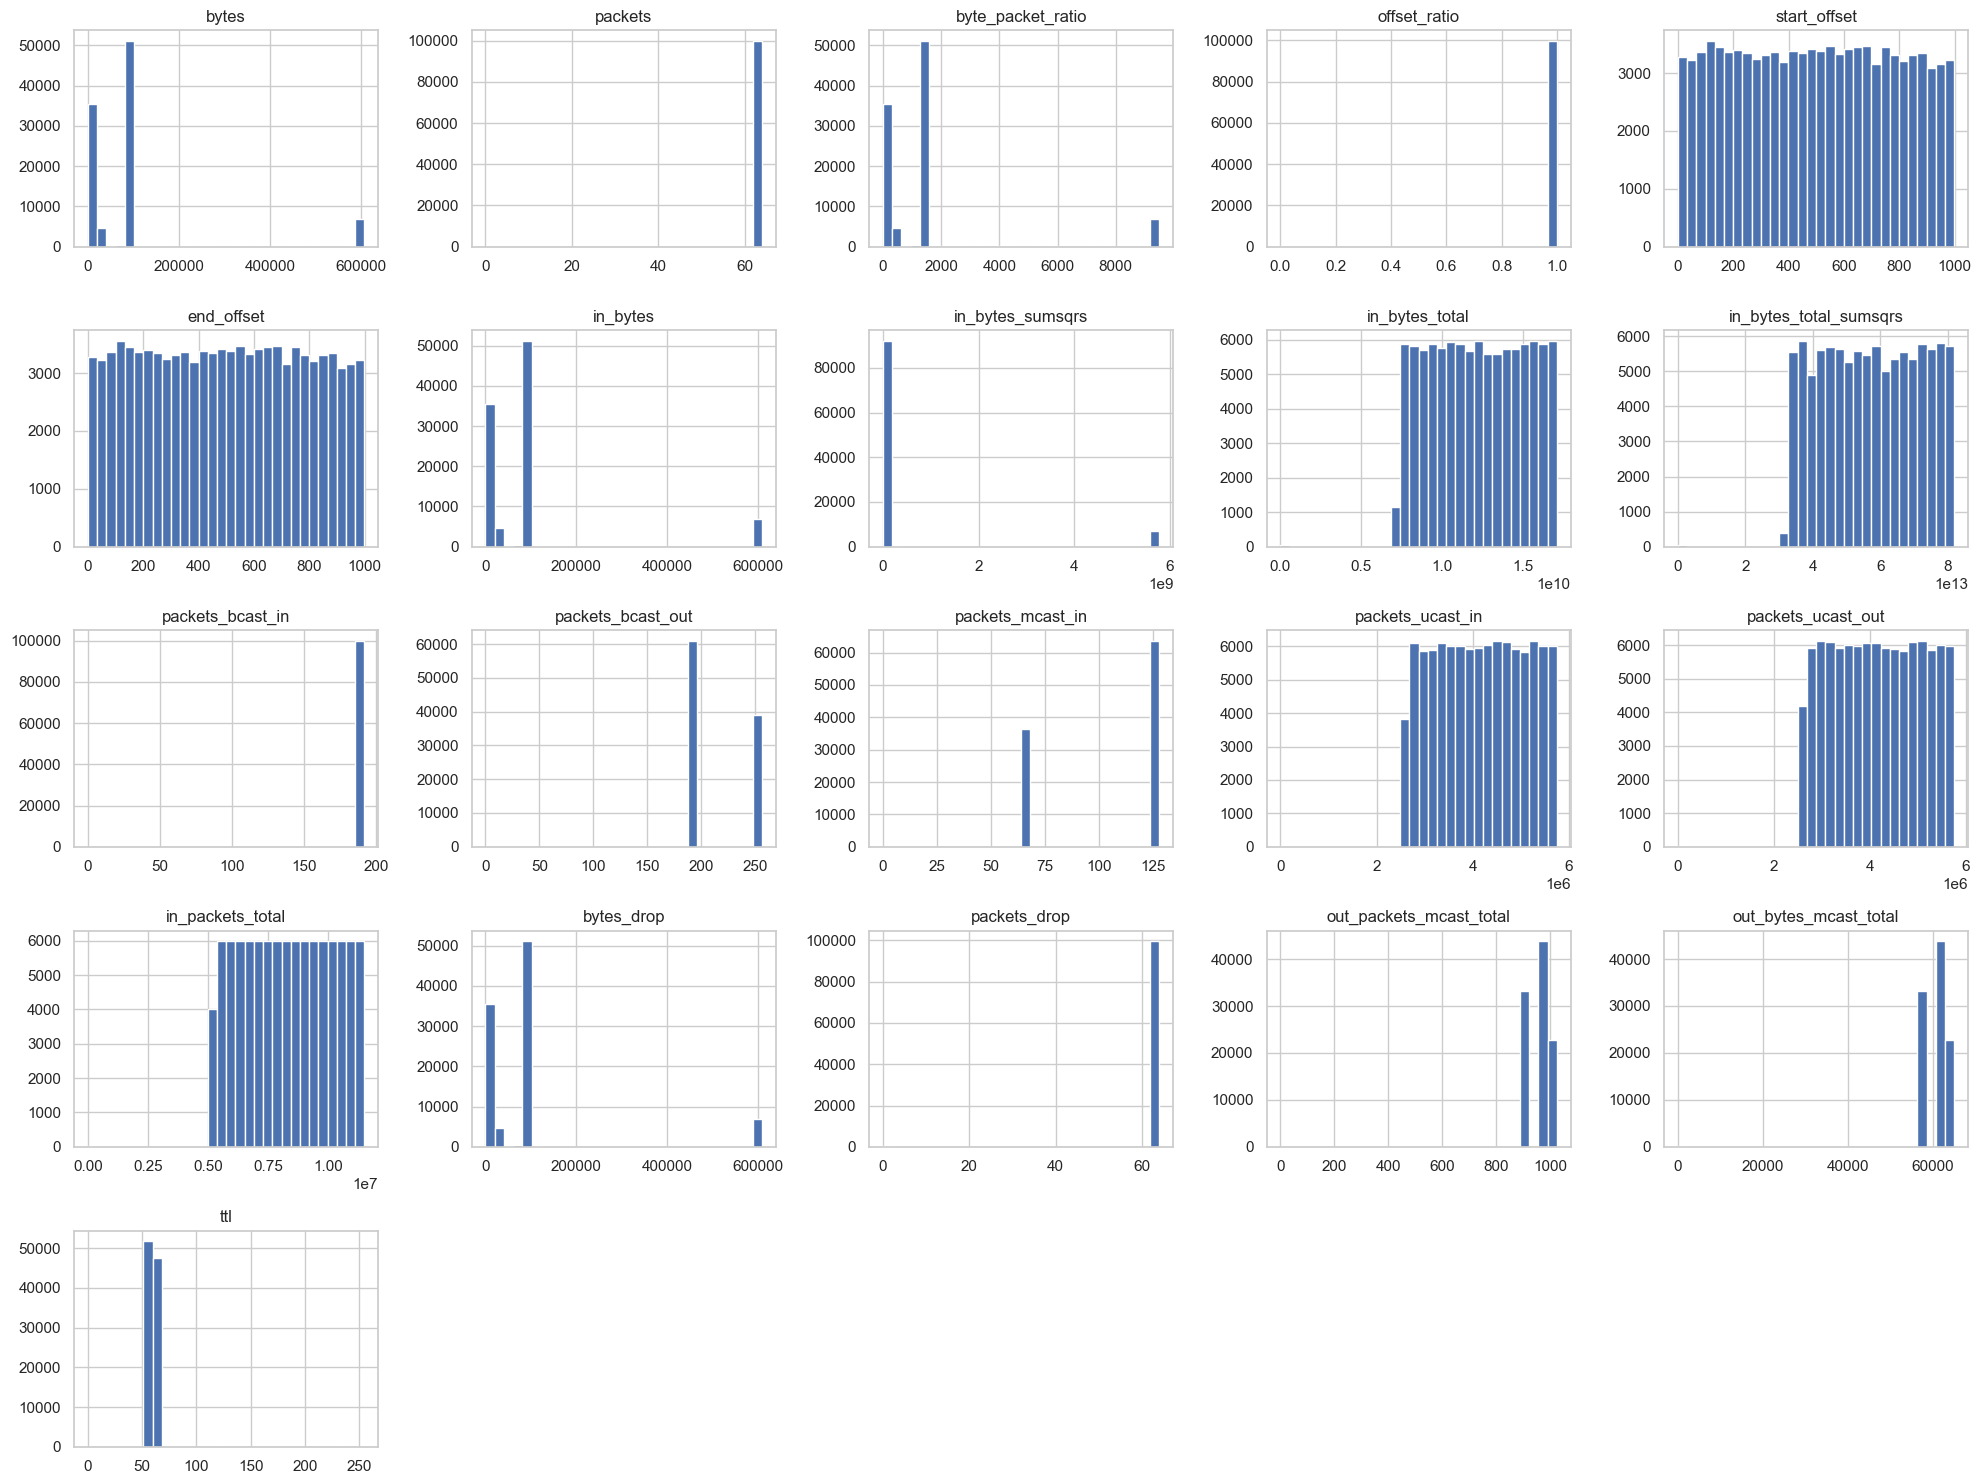

In [4]:
#1 Set a style for the plots
sns.set(style="whitegrid")

# Define the updated numerical features
numerical_features = [
    'bytes', 'packets', 'byte_packet_ratio', 'offset_ratio', 'start_offset', 'end_offset',
    'in_bytes', 'in_bytes_sumsqrs', 'in_bytes_total', 'in_bytes_total_sumsqrs',
    'packets_bcast_in', 'packets_bcast_out', 'packets_mcast_in', 'packets_ucast_in', 'packets_ucast_out',
    'in_packets_total', 'bytes_drop', 'packets_drop', 'out_packets_mcast_total', 'out_bytes_mcast_total', 'ttl'
]
df_numerical = df[numerical_features]

# Plot histograms for each numerical feature
df_numerical.hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()


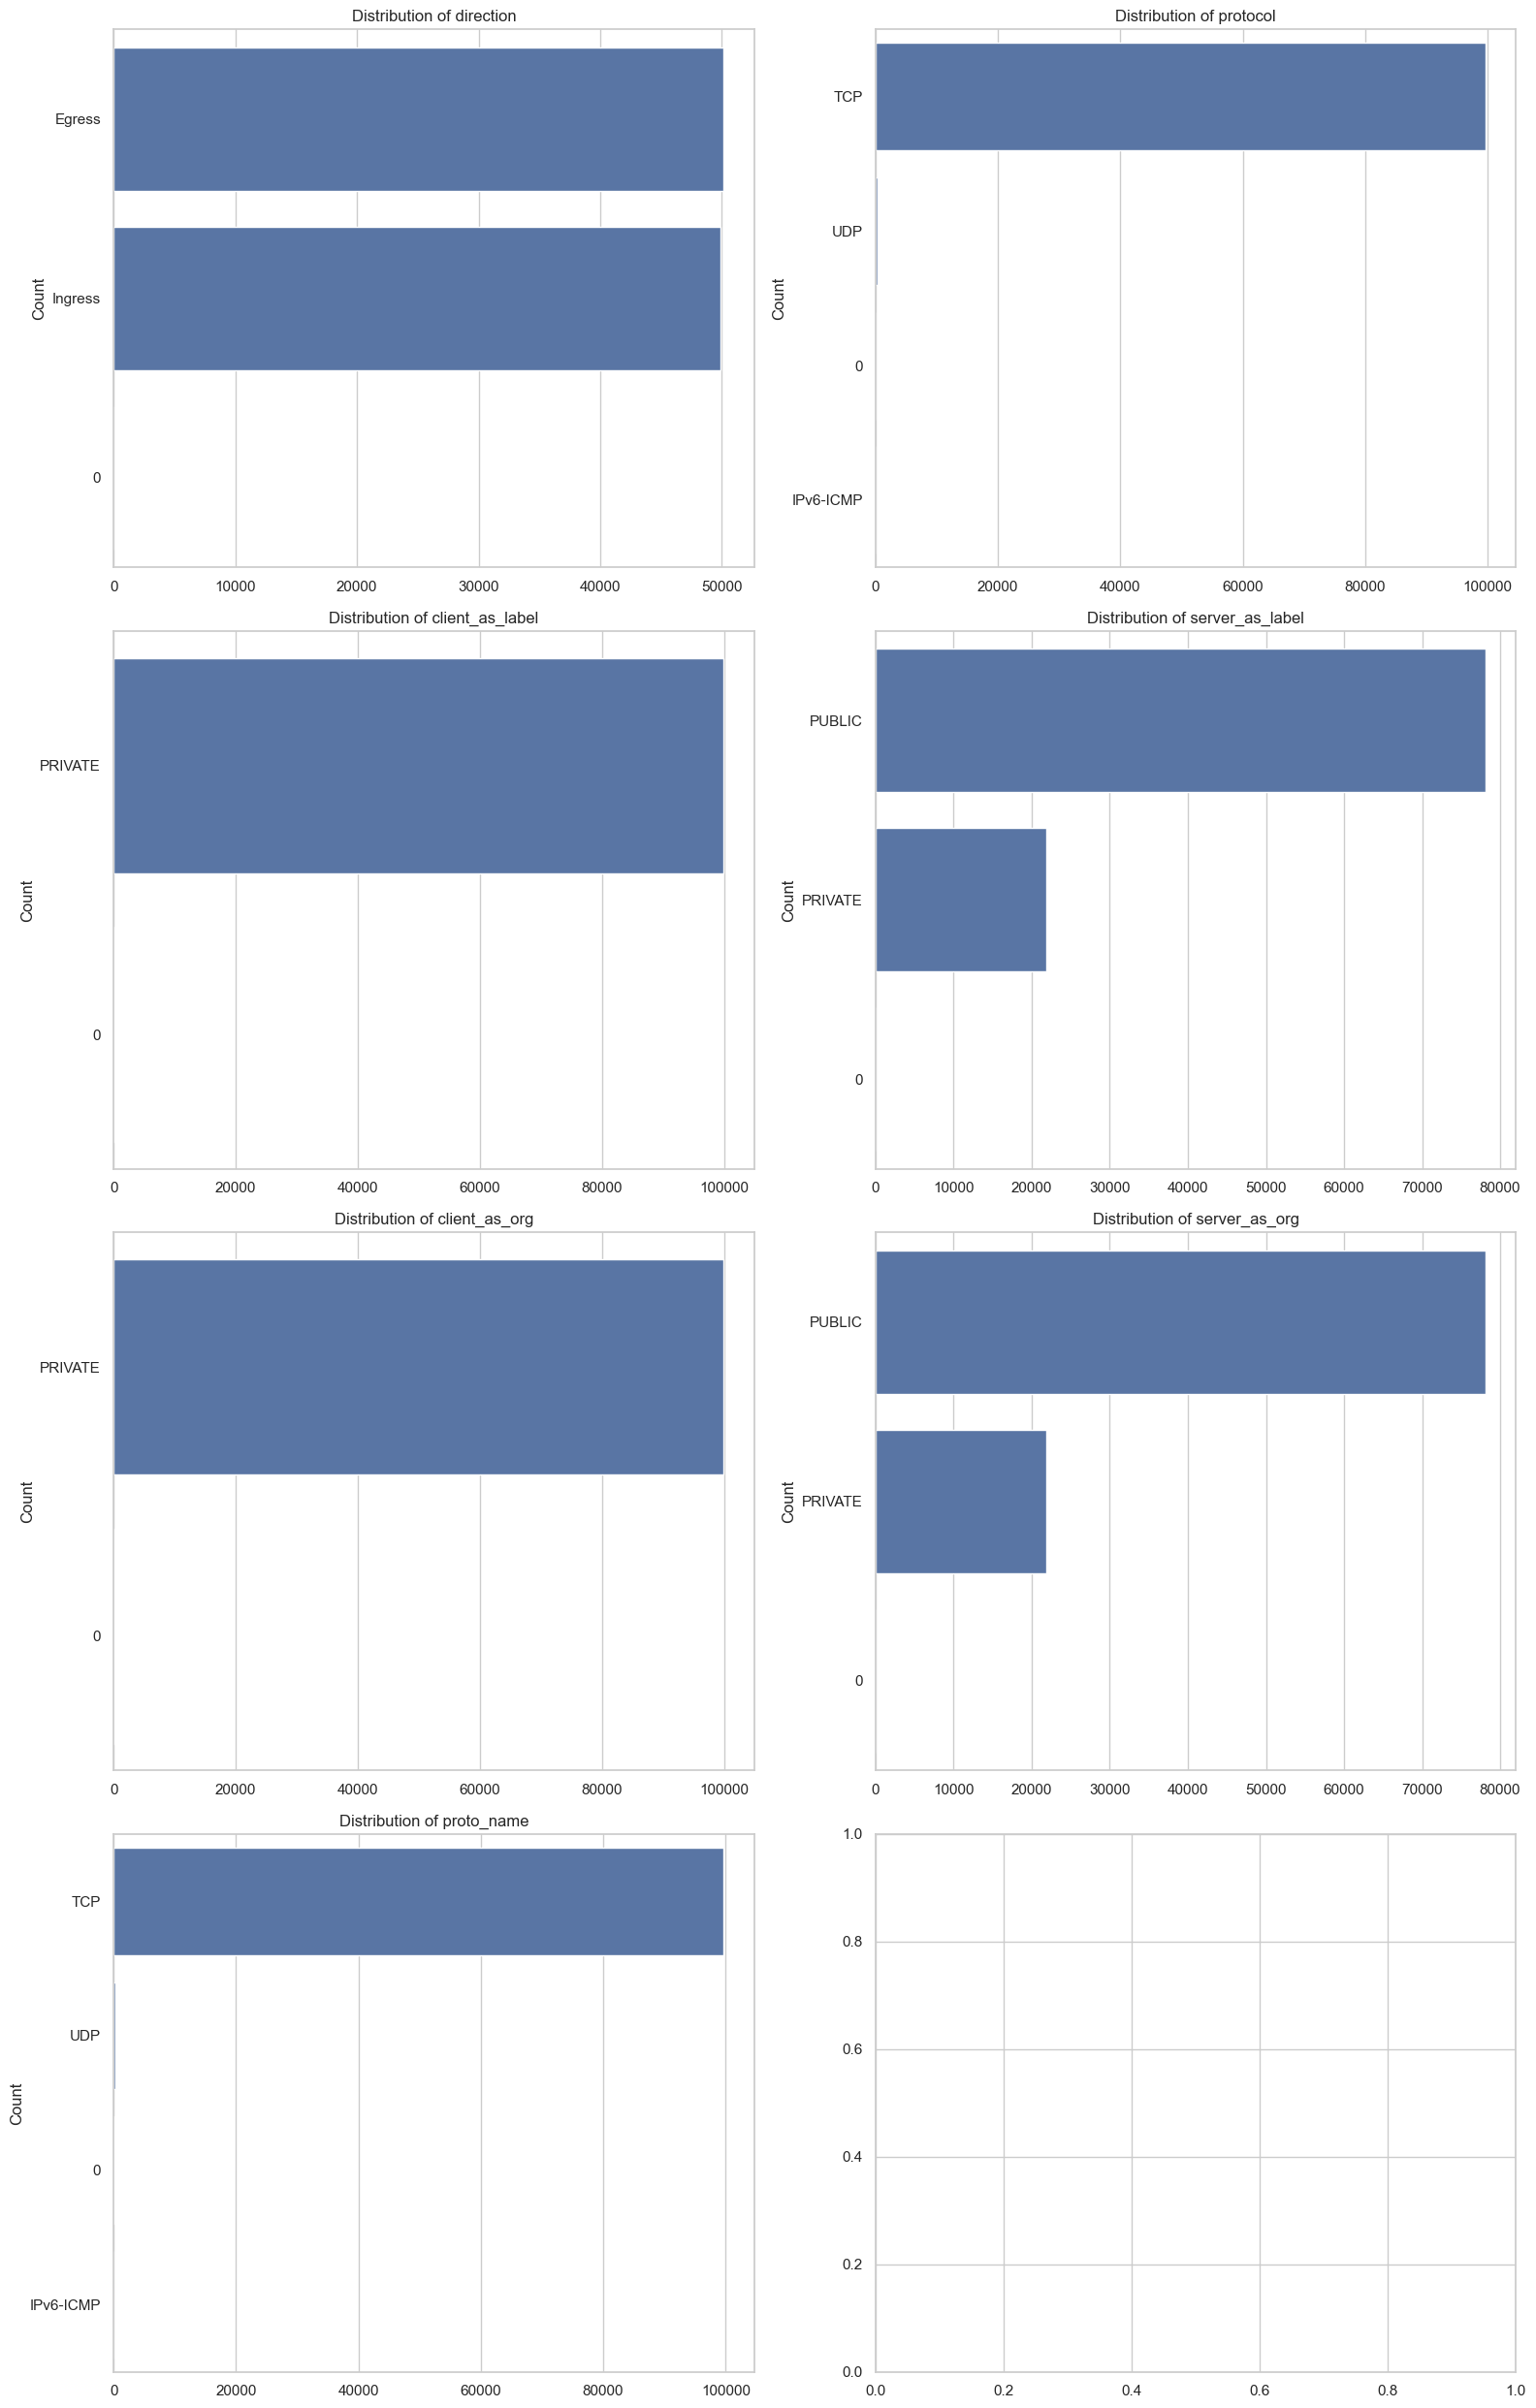

In [5]:
# 2. Plot Bar Charts for Categorical Features
categorical_features = ['direction', 'protocol', 'client_as_label', 'server_as_label', 'client_as_org', 'server_as_org', 'proto_name']

fig, axes = plt.subplots(len(categorical_features) // 2 + len(categorical_features) % 2, 2, figsize=(16, 25))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


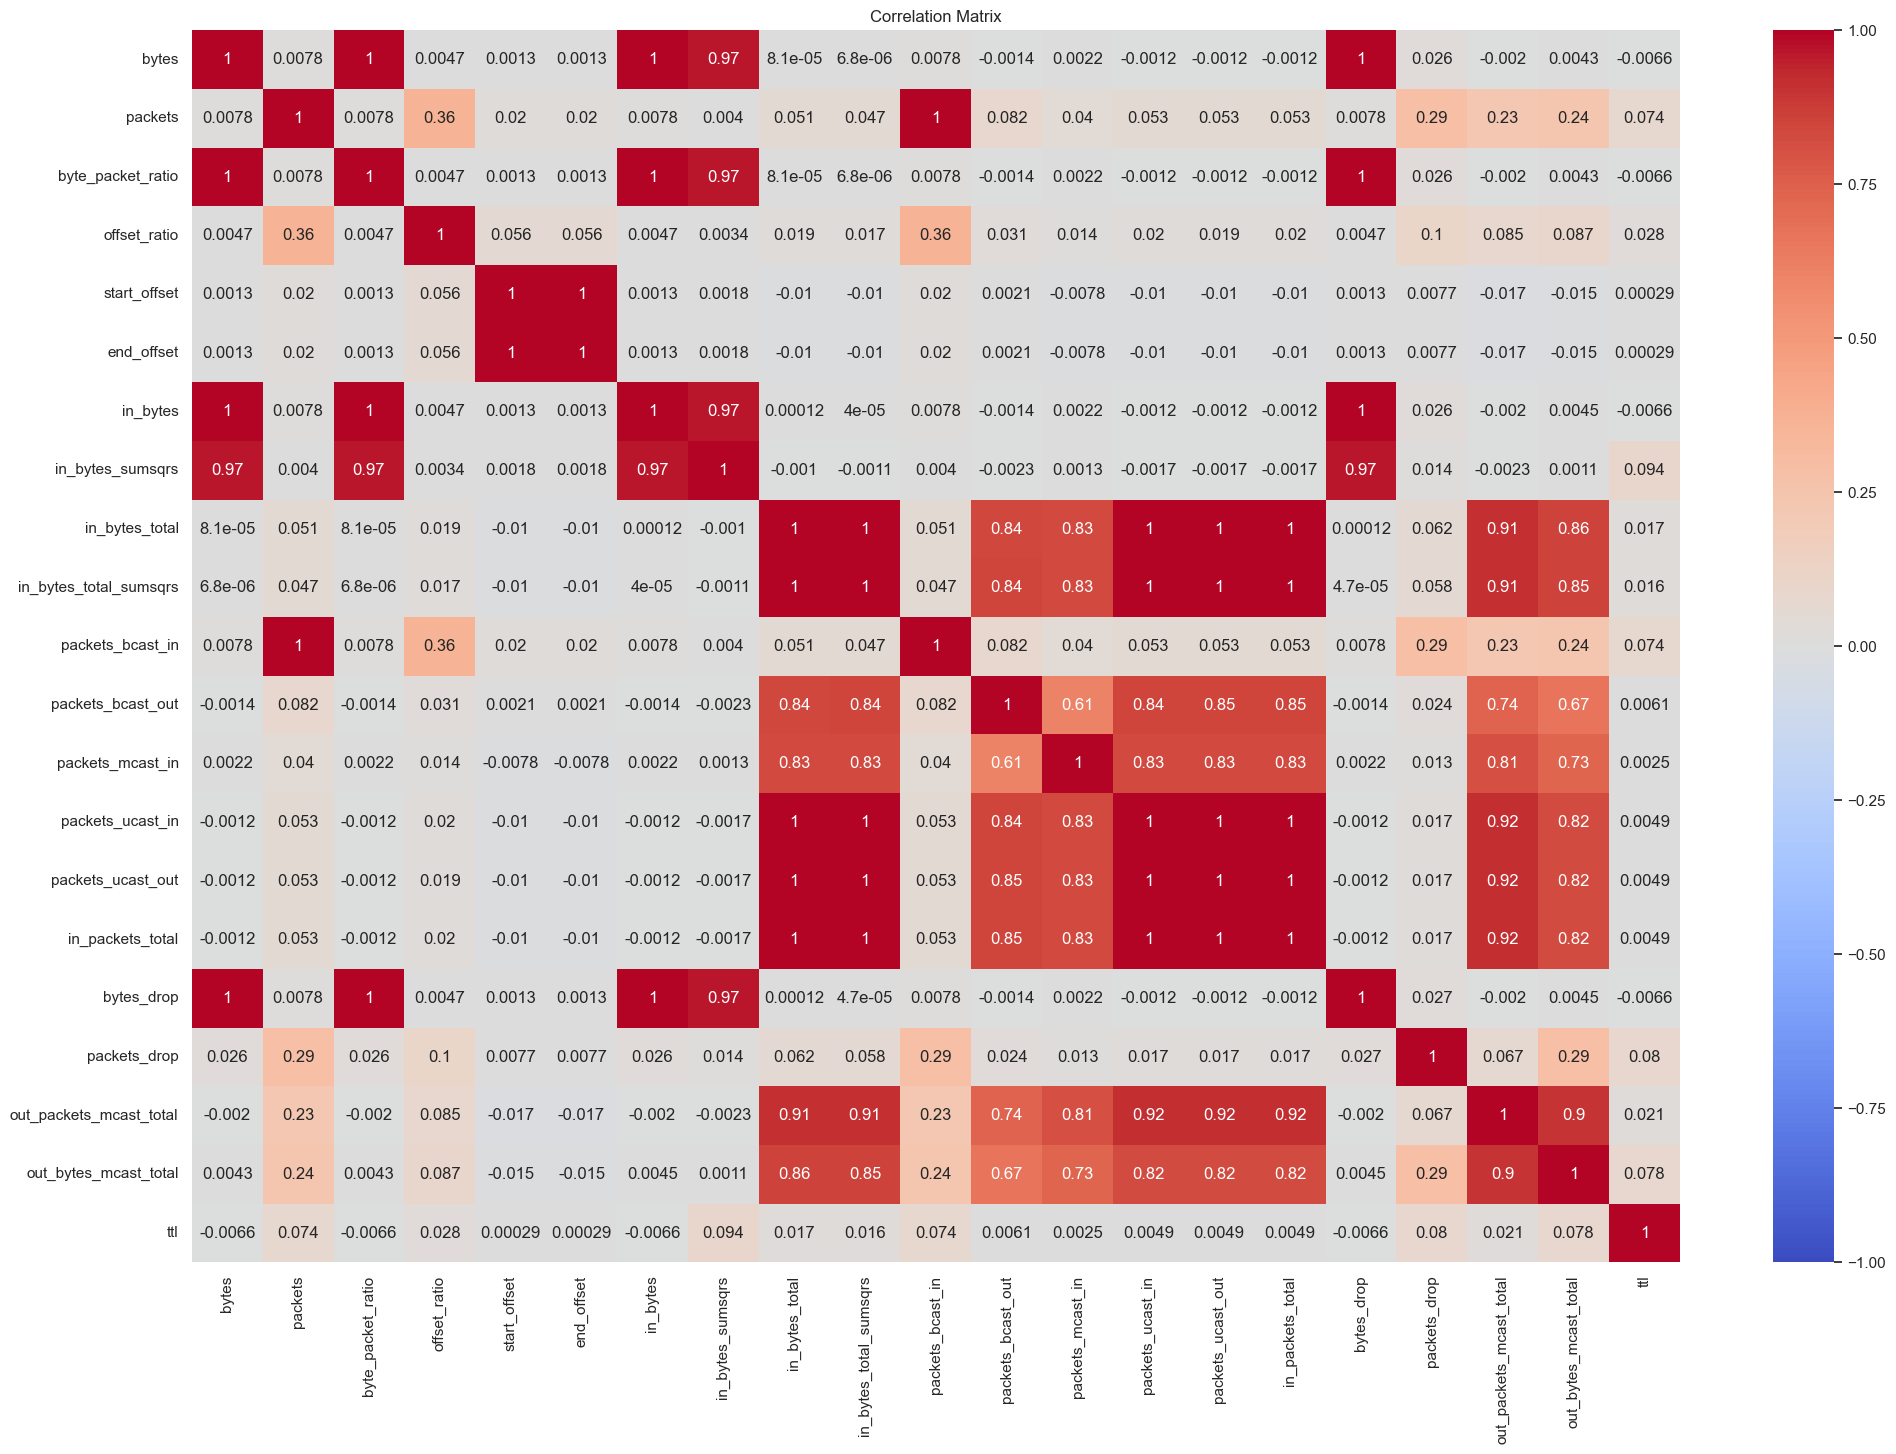

In [6]:
# 3. Correlation Analysis for Numerical Features
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(24, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()




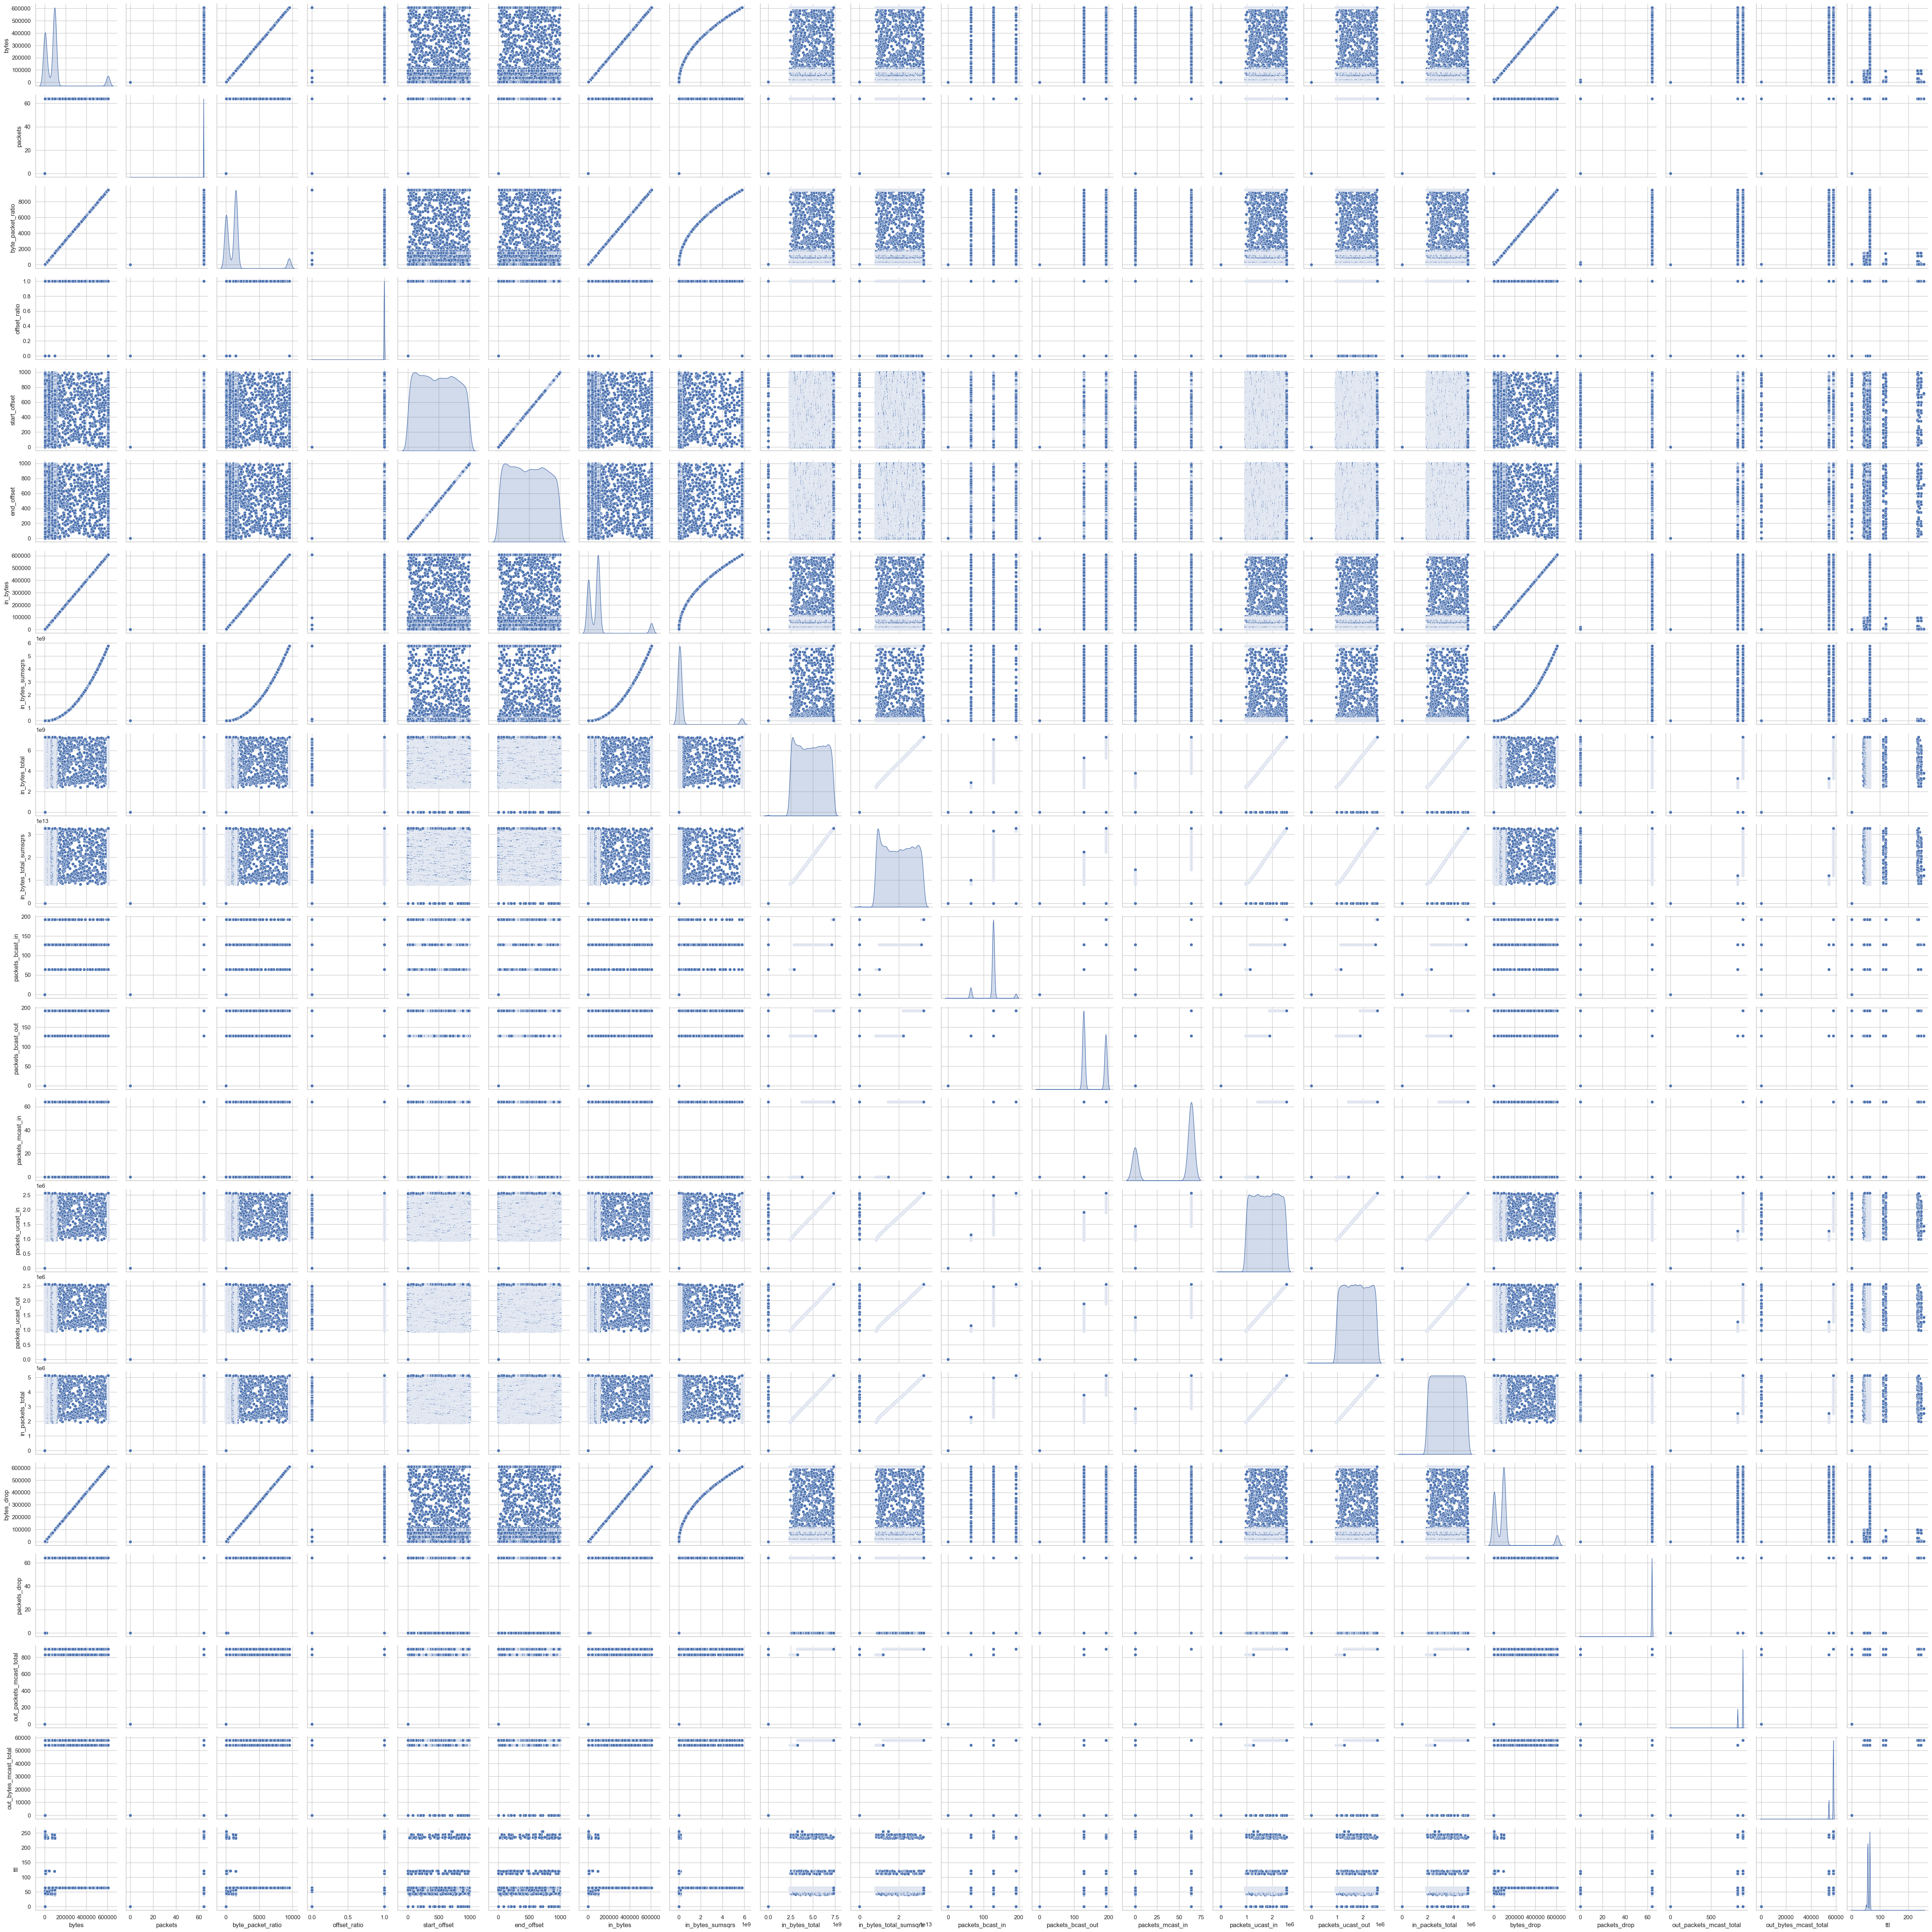

In [11]:
# 4. Pairplot for Numerical Feature Relationships (Optional, can be heavy if data is large)
sns.pairplot(df_numerical, diag_kind='kde')
plt.show()



In [7]:
# Create a label column based on the target MAC address
df['label1'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:01' or row['dst_mac'] == '00:00:00:00:00:01' else 0, axis=1)
df['label2'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:02' or row['dst_mac'] == '00:00:00:00:00:02' else 0, axis=1)
df['label3'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:03' or row['dst_mac'] == '00:00:00:00:00:03' else 0, axis=1)
df['label4'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:04' or row['dst_mac'] == '00:00:00:00:00:04' else 0, axis=1)
df['label5'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:05' or row['dst_mac'] == '00:00:00:00:00:05' else 0, axis=1)
df['label6'] = df.apply(lambda row: 1 if row['src_mac'] == '00:00:00:00:00:06' or row['dst_mac'] == '00:00:00:00:00:06' else 0, axis=1)



In [8]:
print(df['label1'].value_counts())
print(df['label2'].value_counts())
print(df['label3'].value_counts())
print(df['label4'].value_counts())
print(df['label5'].value_counts())
print(df['label6'].value_counts())


label1
0    99364
1      636
Name: count, dtype: int64
label2
0    100000
Name: count, dtype: int64
label3
1    96024
0     3976
Name: count, dtype: int64
label4
0    78167
1    21833
Name: count, dtype: int64
label5
0    96676
1     3324
Name: count, dtype: int64
label6
0    99999
1        1
Name: count, dtype: int64


Results for label1:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29784
           1       0.92      0.46      0.61       216

    accuracy                           1.00     30000
   macro avg       0.96      0.73      0.80     30000
weighted avg       1.00      1.00      1.00     30000



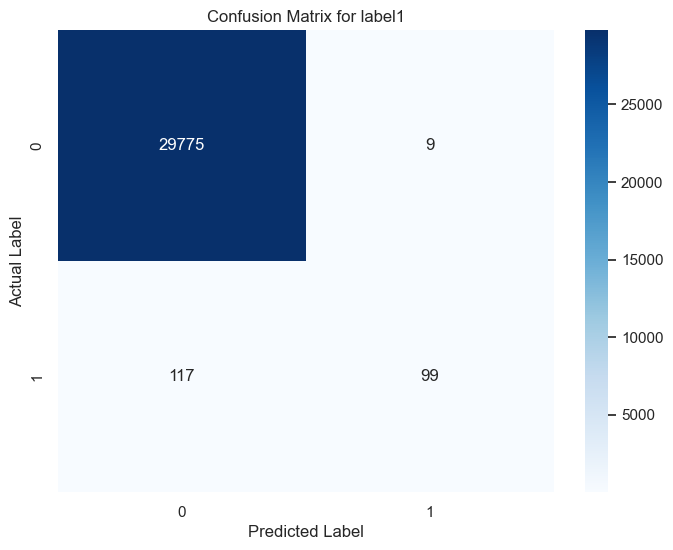

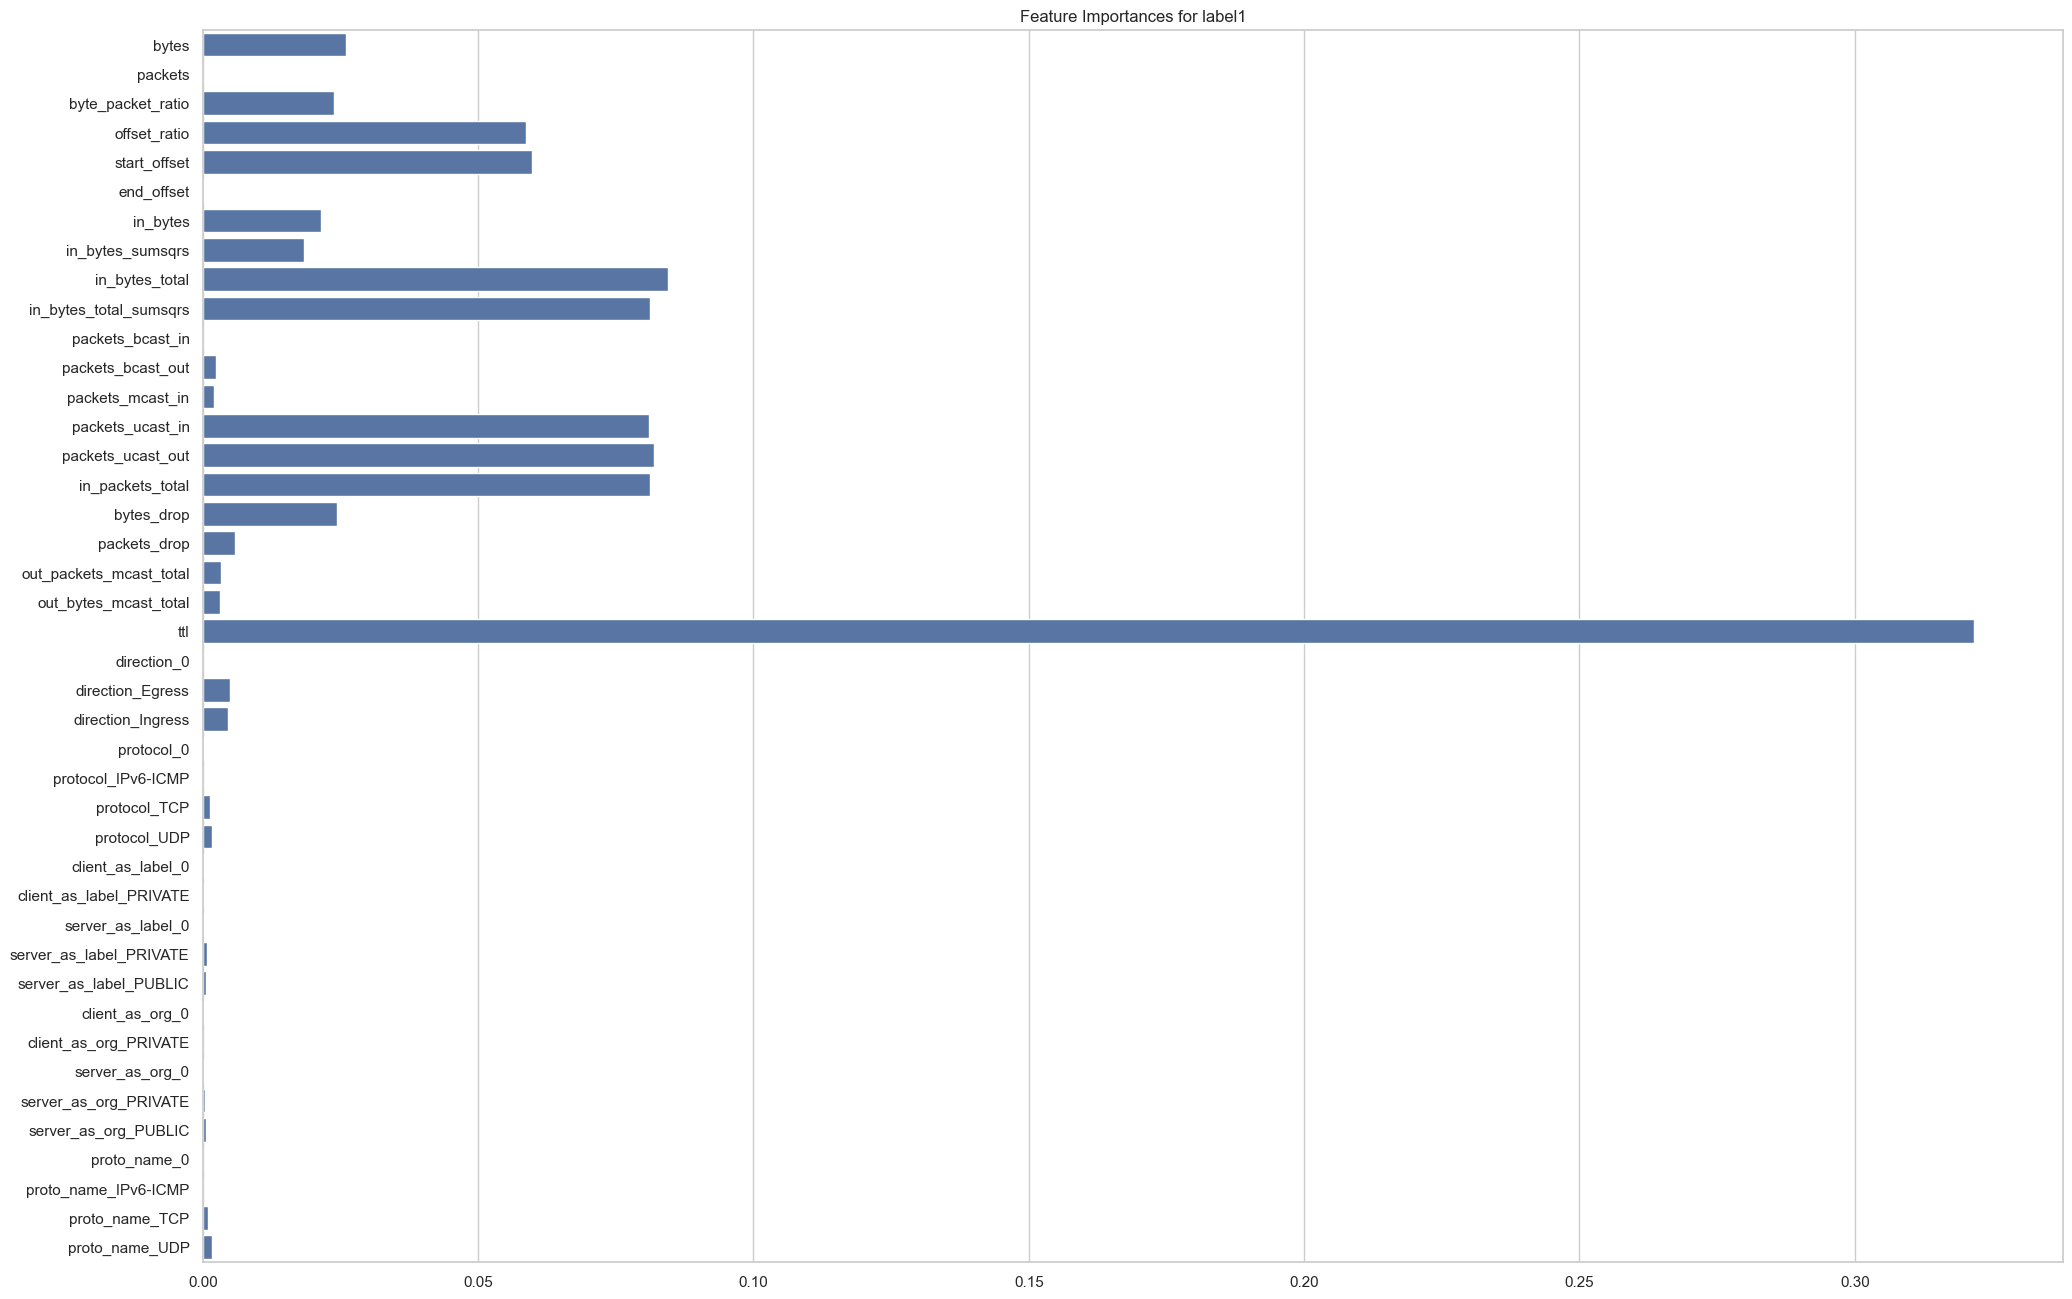

Results for label2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



C:\Users\dayzd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


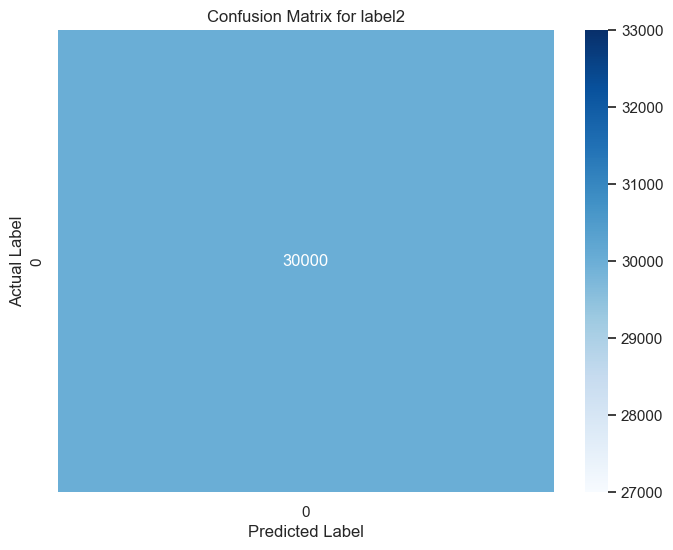

In [ ]:
# Define X (features) and y (labels) for each label
X = df_preprocessed
labels = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']

# Train and evaluate a model for each label
for label in labels:
    y = df[label]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print(f"Results for {label}:")
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importances
    importances = model.feature_importances_
    feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

    # Plotting feature importances
    plt.figure(figsize=(24, 16))
    sns.barplot(x=importances, y=feature_names)
    plt.title(f'Feature Importances for {label}')
    plt.show()